**Connexion to data base**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import os
from dotenv import load_dotenv

In [2]:
# creating file dot.env for protection personal data in the same directory with jupyter notebook
dotenv_path = os.path.join('dot1.env')
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
    
user = os.environ['user']
pwd = os.environ['pwd']
host = os.environ['host']
port = os.environ['port']
db = os.environ['db']

In [3]:
db_config = {
    'user': user, # имя пользователя
    'pwd': pwd, # пароль
    'host': host,
    'port': port, # порт подключения
    'db': db # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:

engine = create_engine(connection_string) 

# 1

Get the total sum of post views for each month of 2008. If there is no data for any month in the database, this month can be skipped. Sort the result in descending order of the total number of views.

In [5]:
query = '''

SELECT DATE_TRUNC('month', creation_date)::date as month, 
       SUM(views_count) as total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY total_views DESC
'''

total_views = pd.read_sql_query(query, con=engine) 
total_views

,month,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


([<matplotlib.axis.XTick at 0x223efdc0908>,
 <a list of 6 Text xticklabel objects>)

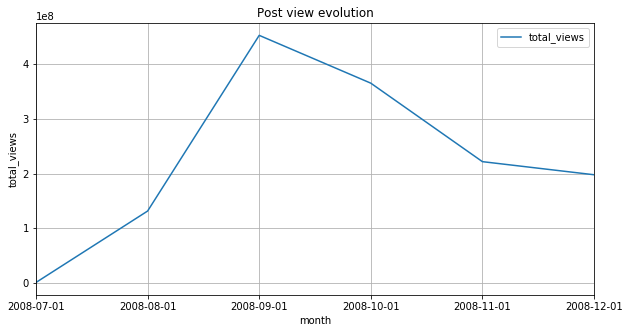

In [6]:
total_views.sort_values(by = 'month').reset_index(drop = True).plot(grid= True, figsize = (10,5)) 
plt.xlabel('month')
plt.ylabel('total_views')
plt.title('Post view evolution')
plt.xticks(ticks = range(len(total_views)), labels = total_views.sort_values(by = 'month')['month'])

# 2

Get the names of the most active users who gave more than 100 responses in the first month after registration (including the day of registration). Questions asked by users, do not count. For each username, print the number of unique `user_id` values. Sort the result by the field with names in lexicographic order.

In [7]:
query = '''

WITH 
a AS (SELECT u.display_name, 
             COUNT(DISTINCT(p.user_id)) as cnt_unique_id, 
             COUNT(*) as cnt
FROM stackoverflow.posts as p 
     JOIN stackoverflow.post_types as pt
     ON p.post_type_id = pt.id AND pt.type = 'Answer'
     
     JOIN stackoverflow.users as u 
     ON u.id = p.user_id AND p.creation_date BETWEEN u.creation_date and u.creation_date + interval'1 month'
GROUP BY u.display_name)

SELECT display_name,
    cnt_unique_id
FROM a
WHERE cnt > 100
ORDER BY display_name

'''
active_users = pd.read_sql_query(query, con=engine) 
active_users

,display_name,cnt_unique_id
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


# 3

Print the number of posts for 2008 by month. Select posts from users who signed up in September 2008 and made at least one post in December of that year. Sort the table by month value in descending order.

In [8]:
query = '''

WITH
a AS (SELECT id
      FROM stackoverflow.users
      WHERE creation_date::varchar LIKE '2008-09-%%'),

b AS (SELECT user_id
     FROM stackoverflow.posts
     WHERE creation_date::varchar LIKE '2008-12-%%')
     
SELECT DATE_TRUNC('month', creation_date)::date as month, 
       COUNT(*) as number_of_posts
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008 
      AND user_id IN (SELECT id FROM a JOIN b ON a.id = b.user_id)
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY month DESC

'''
us_act = pd.read_sql_query(query, con=engine) 
us_act

,month,number_of_posts
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


([<matplotlib.axis.XTick at 0x223f1ea3ec8>,
 <a list of 5 Text xticklabel objects>)

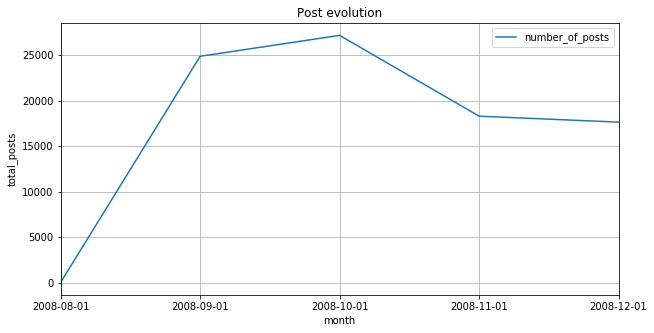

In [9]:
us_act.sort_values(by = 'month').reset_index(drop = True).plot(grid= True, figsize = (10,5)) 
plt.xlabel('month')
plt.ylabel('total_posts')
plt.title('Post evolution')
plt.xticks(ticks = range(len(us_act)), labels = us_act.sort_values(by = 'month')['month'])

# 4

Using the post data, output a few fields:
- ID of the user who wrote the post;
- date of creation of the post;
- the number of views of the current post;
- the amount of views of the author's posts with accumulation.
The data in the table should be sorted in ascending order of user IDs, and the data for the same user should be sorted in ascending order of the date the post was created.

In [10]:
query = '''
SELECT user_id, 
       creation_date, 
       views_count, 
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) as cum_count
FROM stackoverflow.posts
ORDER BY user_id
'''
pd.read_sql_query(query, con=engine).set_index('user_id') 


,creation_date,views_count,cum_count
user_id,,,
1,2008-07-31 23:41:00,480476,480476
1,2008-07-31 23:55:38,136033,616509
1,2008-07-31 23:56:41,0,616509
1,2008-08-04 02:45:08,0,616509
1,2008-08-04 04:31:03,0,616509
...,...,...,...
5696608,2008-12-23 16:00:37,0,2804
5696608,2008-12-23 17:35:09,0,2804
5696608,2008-12-24 01:02:48,0,2804


# 5

Find the average number of user posts per day for August 2008. Select data about users who published more than 120 posts in August. Do not count days without posting.
Sort the result in ascending order of the average number of posts

In [11]:
query = '''
WITH 
a AS (SELECT user_id, 
             COUNT(*)
      FROM stackoverflow.posts
      WHERE EXTRACT(YEAR from creation_date) = 2008 AND EXTRACT(MONTH from creation_date) = 8
      GROUP BY user_id
      HAVING COUNT(*)>120),

c as (SELECT user_id, 
              DATE_TRUNC('day',creation_date)::date, 
              COUNT(*)
       FROM stackoverflow.posts 
       WHERE user_id IN (SELECT user_id from a) AND DATE_TRUNC('day',creation_date)::varchar LIKE '2008-08-%%'
       GROUP BY user_id, DATE_TRUNC('day',creation_date)::date)

SELECT user_id, 
       SUM(count)/COUNT(count) as avg_post
FROM c
GROUP BY user_id
ORDER BY avg_post
'''
pd.read_sql_query(query, con=engine).set_index('user_id')

,avg_post
user_id,
116,4.777778
234,5.208333
91,5.681818
905,7.000000
383,7.277778


# 6

On average, how many days between 1 December 2008 and 7 December 2008 did users interact with the platform? For each user, select the days on which he or she posted at least one post. You need to get a single integer - do not forget to round the result.

In [12]:
query = '''
WITH 
a AS (SELECT user_id, 
             COUNT(*) as cnt
      FROM stackoverflow.posts
      WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
      GROUP BY user_id)

SELECT ROUND(AVG(cnt), 0)::int as result
FROM a
'''
pd.read_sql_query(query, con=engine).set_index('result')

""
result
3


# 7

Display the activity history of each user in this form: user ID, post publication date. Sort the output by ascending user ID, and for each user by ascending publication date.
Add a new field to the table: for each post, it will contain the name of the month of the user's penultimate publication relative to the current one. If there is no such publication, specify `NULL`.  

In [13]:
query = '''
WITH 
a as
(SELECT DISTINCT user_id, creation_date, LAG(creation_date) OVER (PARTITIOn BY user_id ORDER BY creation_date) as last_month
FROM stackoverflow.posts
ORDER BY user_id,  creation_date)
SELECT user_id, creation_date, to_char(LAG(last_month) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month') as second_last_month
FROM a
'''
pd.read_sql_query(query, con=engine).set_index('user_id')

,creation_date,second_last_month
user_id,,
1,2008-07-31 23:41:00,None
1,2008-07-31 23:55:38,None
1,2008-07-31 23:56:41,July
1,2008-08-04 02:45:08,July
1,2008-08-04 04:31:03,July
...,...,...
5696608,2008-12-23 16:00:37,December
5696608,2008-12-23 17:35:09,December
5696608,2008-12-24 01:02:48,December


# 8

Calculate the Retention Rate for StackOverflow users. Organize users into cohorts based on the month of their first post. Return is determined by the presence of a post in the current month.

In [14]:
query = '''
WITH 
profiles AS (SELECT user_id, MIN(DATE_TRUNC('month', creation_date)::date) as cohort_start
FROM stackoverflow.posts
GROUP BY user_id),
cohort_size AS (SELECT cohort_start, COUNT(user_id) as cohort_size
FROM profiles 
GROUP BY cohort_start
ORDER BY cohort_start), 
sessions as (SELECT cohort_start, user_id, cohort_size, creation_date FROM profiles JOIN cohort_size USING(cohort_start) JOIN stackoverflow.posts USING (user_id))
SELECT  cohort_start, 
        DATE_TRUNC('month',creation_date)::date as session_month, 
        COUNT(DISTINCT(user_id)) as cnt_user, 
        cohort_size,
        ROUND(COUNT(DISTINCT(user_id))::numeric/cohort_size*100, 2) as retention
FROM sessions
GROUP BY cohort_start, DATE_TRUNC('month',creation_date)::date, cohort_size
ORDER BY cohort_start, DATE_TRUNC('month',creation_date)::date
'''
retention = pd.read_sql_query(query, con=engine)
retention

,cohort_start,session_month,cnt_user,cohort_size,retention
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


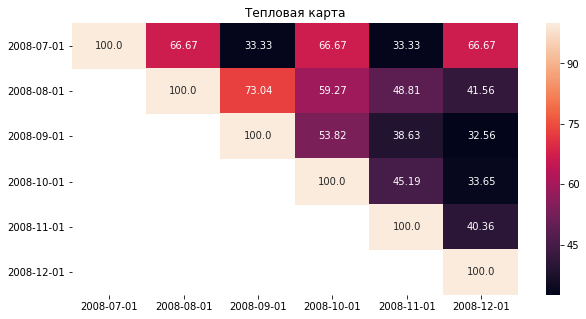

In [15]:
retention = retention.pivot('cohort_start', 'session_month', 'retention')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(10,5)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта')
plt.show() 

#  9


By what percent did the number of posts change monthly from September 1 to December 31, 2008? Display a table with the following fields:

- month number;
- the number of posts per month;
- a percentage that shows how much the number of posts in the current month has changed compared to the previous one.

In [16]:
# напишите запрос
query = '''
WITH 
a AS (SELECT EXTRACT(month from creation_date)::int as month, 
             COUNT(*) as total_posts
      FROM stackoverflow.posts
      WHERE EXTRACT(YEAR from creation_date) = 2008 AND EXTRACT(MONTH from creation_date) IN (9,10,11,12)
      GROUP BY EXTRACT(month from creation_date))
      
SELECT *, 
       ROUND((total_posts::numeric/LAG(total_posts) OVER() - 1)*100, 2) as percent
FROM a

'''
pie = pd.read_sql_query(query, con=engine).set_index('month')
pie
# выполните запрос

,total_posts,percent
month,,
9,70371,NaN
10,63102,-10.33
11,46975,-25.56
12,44592,-5.07


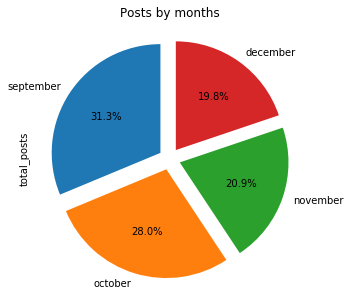

In [17]:
labels=['september','october','november','december']
explode=(0.1,0.1,0.1,0.1)
pie.plot.pie(y='total_posts', figsize=(5, 5), title="Posts by months", 
             labels = labels, legend = False, explode = explode, autopct='%1.1f%%', startangle=90)

# 10

Download the activity data of the user who posted the most posts of all time. Output the data for October 2008 :
- week number;
- date and time of the last post published this week.

In [18]:
# напишите запрос
query = '''
WITH 
a AS (SELECT user_id, 
             COUNT(*) 
      FROM stackoverflow.posts
      GROUP BY user_id
      ORDER BY COUNT(*) DESC
      LIMIT 1)

      
SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::int as week, 
       MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date))
FROM stackoverflow.posts 
WHERE user_id = (SELECT user_id FROM a) AND creation_date::varchar LIKE '2008-10-%%'
ORDER BY week
'''
pd.read_sql_query(query, con=engine).set_index('week')


,max
week,
40,2008-10-05 09:00:58
41,2008-10-12 21:22:23
42,2008-10-19 06:49:30
43,2008-10-26 21:44:36
44,2008-10-31 22:16:01
